In [345]:
#日付
import datetime
#平方根
from math import sqrt
#numpyのインストール
import numpy as np
#pandasのインストール
import pandas as pd
#statistics
import statistics as st
#statsmodelsのインストール
import statsmodels.api as sm
#時系列モデルのインストール
from statsmodels.tsa import stattools as st
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.arima_model import ARMA,ARIMA
#scikit-learnのインストール
import sklearn.linear_model as lm
#msnoのインストール
import missingno as msno
#pyplotのインストール
import matplotlib.pyplot as plt
#seabornのインストール
import seaborn as sns
%matplotlib inline
sns.set()
lr = lm.LogisticRegression()

In [229]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
w_data = pd.read_csv('data4.csv', index_col='year', parse_dates=True)

In [3]:
w_data = w_data.loc[:'2015-12-01']

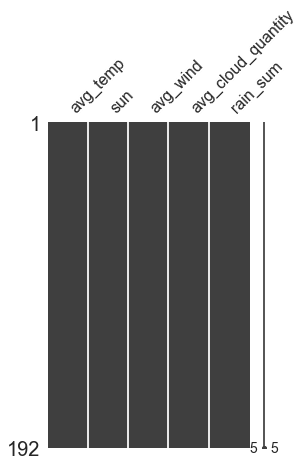

In [4]:
#データ欠損の確認 (欠損なし！)
msno.matrix(df=w_data,figsize=(4,6))

# ADF検定（単位根検定の資料）
## https://www.slideshare.net/teramonagi/r-7066155
## P-values > 0.05 then, 単位根
## wind, cloudが単位根、それ以外が定常性を持つ

In [5]:
#原系列に対するADF検定
print (st.adfuller(w_data['avg_temp'].values.ravel()))
print (st.adfuller(w_data['sun'].values.ravel()))
print (st.adfuller(w_data['avg_wind'].values.ravel()))
print (st.adfuller(w_data['rain_sum'].values.ravel()))
print (st.adfuller(w_data['avg_cloud_quantity'].values.ravel()))

(-3.2900637663836467, 0.015328508913554114, 13, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 560.484979923089)
(-5.616589192480479, 1.170606324354971e-06, 5, 186, {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}, 1800.7981370591356)
(-1.9690874586506262, 0.3002894367029275, 13, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 133.76320669439235)
(-7.969310934484765, 2.8091012202364616e-12, 9, 182, {'1%': -3.4668001583460613, '5%': -2.8775552336674317, '10%': -2.5753075498128246}, 2119.8995652066324)
(-2.8600582212346004, 0.05019373726663235, 12, 179, {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}, 498.0715668537154)


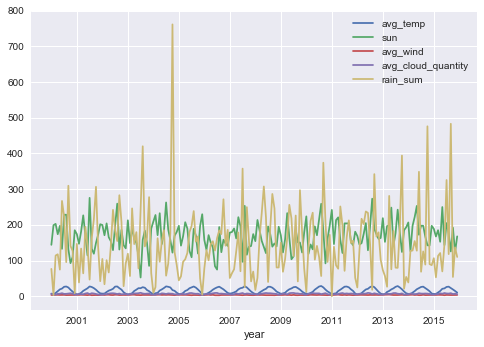

In [6]:
#原系列のplot
w_data.plot()

In [7]:
##各移動平均と差分系列を取得
#気温
temp_data = w_data.loc[:,['avg_temp']]
temp_moving_avg = temp_data.rolling(window=12).mean().dropna()
temp_diff = temp_data.diff().dropna()
#日差し
sun_data = w_data.loc[:,['sun']]
sun_moving_avg = sun_data.rolling(window=12).mean().dropna()
sun_diff = sun_data.diff().dropna()
#風量
wind_data = w_data.loc[:,['avg_wind']]
wind_moving_avg = wind_data.rolling(window=12).mean().dropna()
wind_diff = wind_data.diff().dropna()
#雨量
rain_data = w_data.loc[:,['rain_sum']]
rain_moving_avg = rain_data.rolling(window=12).mean().dropna()
rain_diff = rain_data.diff().dropna()
#雲量
cloud_data = w_data.loc[:,['avg_cloud_quantity']]
cloud_moving_avg = cloud_data.rolling(window=12).mean().dropna()
cloud_diff = cloud_data.diff().dropna()

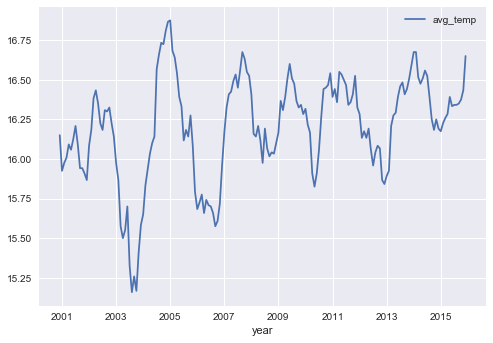

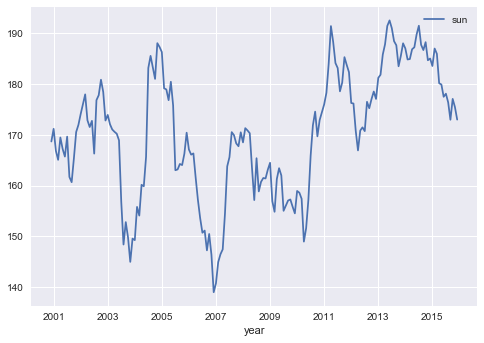

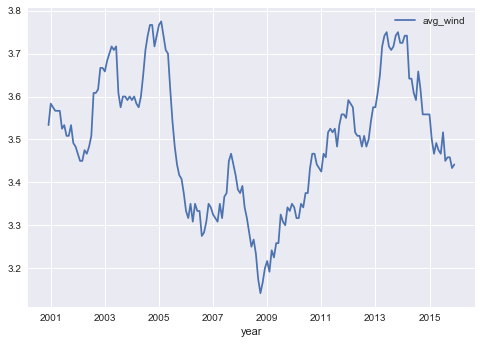

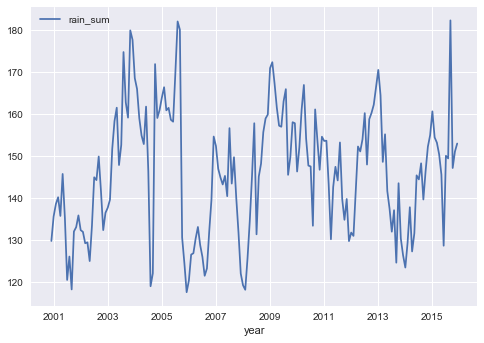

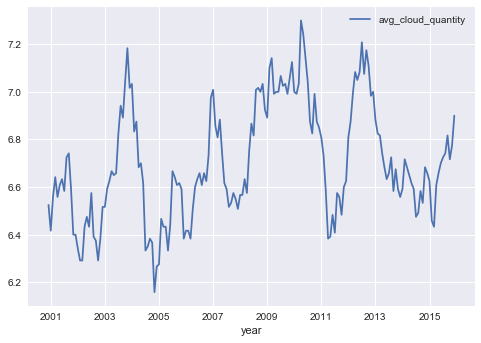

In [8]:
temp_moving_avg.plot()
sun_moving_avg.plot()
wind_moving_avg.plot()
rain_moving_avg.plot()
cloud_moving_avg.plot()

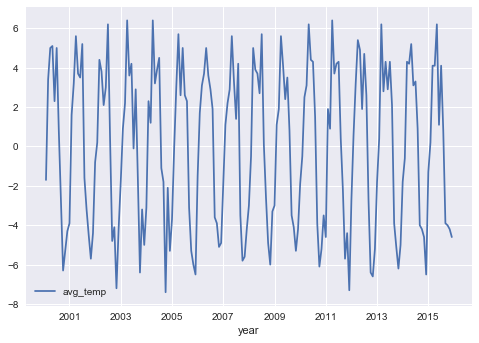

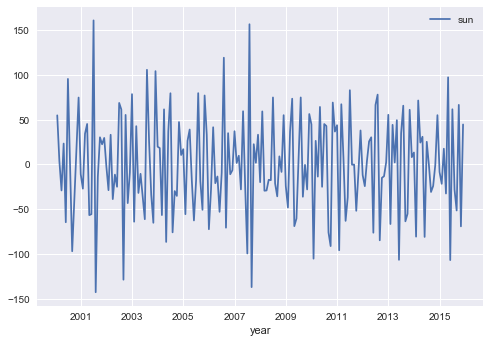

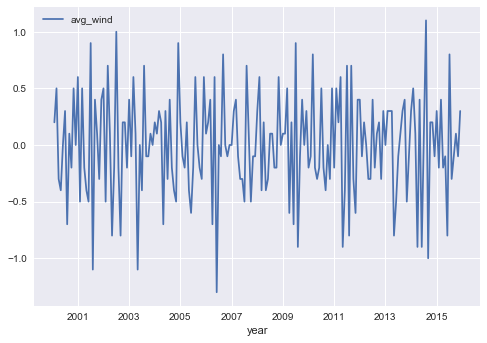

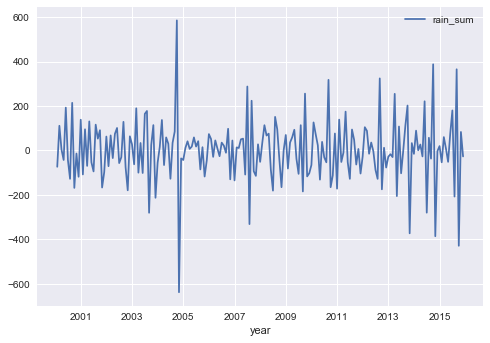

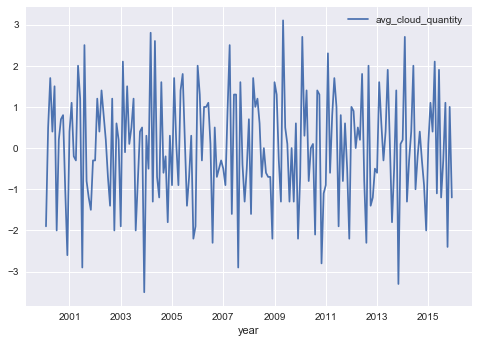

In [9]:
#差分系列のplot
temp_diff.plot()
sun_diff.plot()
wind_diff.plot()
rain_diff.plot()
cloud_diff.plot()

In [10]:
diff_data = pd.concat([temp_diff,sun_diff,wind_diff,rain_diff,cloud_diff],axis=1)

In [11]:
#差分系列をADF検定
print (st.adfuller(temp_diff['avg_temp'].values.ravel()))
print (st.adfuller(sun_diff['sun'].values.ravel()))
print (st.adfuller(wind_diff['avg_wind'].values.ravel()))
print (st.adfuller(rain_diff['rain_sum'].values.ravel()))
print (st.adfuller(cloud_diff['avg_cloud_quantity'].values.ravel()))

(-14.539882507213544, 5.166437389404259e-27, 10, 180, {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}, 565.3020708815486)
(-7.518328327120599, 3.849946412942869e-11, 10, 180, {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}, 1801.6282255373058)
(-12.10730820681971, 1.9554655283788218e-22, 10, 180, {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}, 135.59317233937634)
(-9.35432077163203, 8.136352482873382e-16, 12, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 2127.3578049228154)
(-10.686799428742827, 3.814864619840895e-19, 11, 179, {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}, 502.1098189982017)


# 差分をとることで単位根過程から、定常過程になった
## なので、差分系列同士で相関関係を確認する!

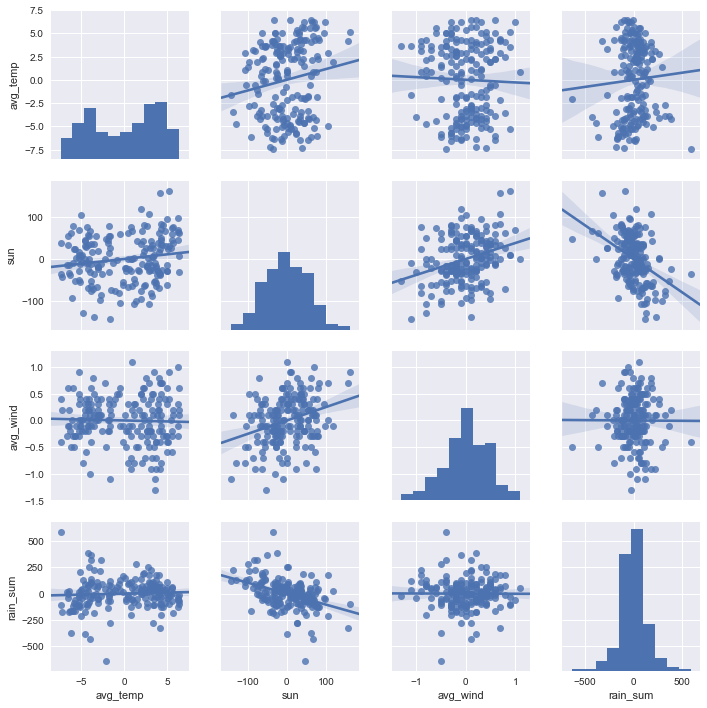

In [178]:
sns.pairplot(diff_data,kind='reg')

In [179]:
correlation_matrix = np.corrcoef(diff_data.transpose())

In [180]:
names = ['avg_temp','sun','avg_wind','rain_sum','cloud_quantity']

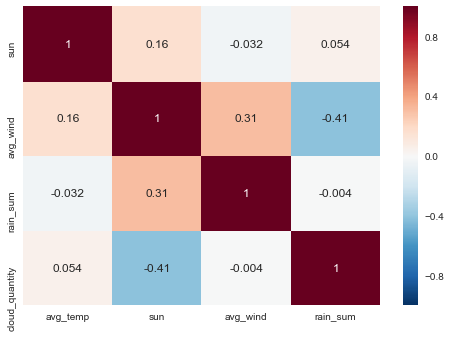

In [181]:
sns.heatmap(correlation_matrix, annot=True, xticklabels=names,yticklabels=names)

# Cloud quantityは日差しとか、気温とかとあまりにも相関するからバイバイする

In [16]:
w_data = w_data.drop(['avg_cloud_quantity'],axis=1)
diff_data = diff_data.drop(['avg_cloud_quantity'],axis=1)

# 横浜市のデータを読み込む！

# うまく書けなかった。。
num=2000
df = pd.DataFrame()

for i in range (15):
    df = df.append(pd.read_excel('yoko_econ.xlsx',sheetname=2016))
    num += 1

In [17]:
dat2000 = pd.read_excel('yoko_econ.xlsx',sheetname='2000').T.drop(['平均'],axis=0).reset_index()
dat2001 = pd.read_excel('yoko_econ.xlsx',sheetname='2001').T.drop(['平均'],axis=0).reset_index()
dat2002 = pd.read_excel('yoko_econ.xlsx',sheetname='2002').T.drop(['平均'],axis=0).reset_index()
dat2003 = pd.read_excel('yoko_econ.xlsx',sheetname='2003').T.drop(['平均'],axis=0).reset_index()
dat2004 = pd.read_excel('yoko_econ.xlsx',sheetname='2004').T.drop(['平均'],axis=0).reset_index()
dat2005 = pd.read_excel('yoko_econ.xlsx',sheetname='2005').T.drop(['平均'],axis=0).reset_index()
dat2006 = pd.read_excel('yoko_econ.xlsx',sheetname='2006').T.drop(['平均'],axis=0).reset_index()
dat2007 = pd.read_excel('yoko_econ.xlsx',sheetname='2007').T.drop(['平均'],axis=0).reset_index()
dat2008 = pd.read_excel('yoko_econ.xlsx',sheetname='2008').T.drop(['平均'],axis=0).reset_index()
dat2009 = pd.read_excel('yoko_econ.xlsx',sheetname='2009').T.drop(['平均'],axis=0).reset_index()
dat2010 = pd.read_excel('yoko_econ.xlsx',sheetname='2010').T.drop(['平均'],axis=0).reset_index()
dat2011 = pd.read_excel('yoko_econ.xlsx',sheetname='2011').T.drop(['平均'],axis=0).reset_index()
dat2012 = pd.read_excel('yoko_econ.xlsx',sheetname='2012').T.drop(['平均'],axis=0).reset_index()
dat2013 = pd.read_excel('yoko_econ.xlsx',sheetname='2013').T.drop(['平均'],axis=0).reset_index()
dat2014 = pd.read_excel('yoko_econ.xlsx',sheetname='2014').T.drop(['平均'],axis=0).reset_index()
dat2015 = pd.read_excel('yoko_econ.xlsx',sheetname='2015').T.drop(['平均'],axis=0).reset_index()
#dat2016は平均値をもたないよ（）

/Users/Taishi/anaconda/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [188]:
#縦型のデータに突合する
dat = pd.concat([dat2000,dat2001,dat2002,dat2003,dat2004,dat2005,dat2006,dat2007,dat2008,dat2009,dat2010,dat2011,dat2012,dat2013,dat2014,dat2015],axis=0)

In [189]:
tar_data = dat.set_index('index').loc[:,['消費支出','食料','住居','光熱・水道','家具・家事用品','被服及び履物','保健医療','交通・通信','教育','教養娯楽','その他の消費支出']]

In [190]:
##各移動平均と差分系列を取得
#消費
consumption_data = tar_data.loc[:,['消費支出']]
consumption_moving_avg = consumption_data.rolling(window=12).mean().dropna()
consumption_diff = consumption_data.diff().dropna().dropna()
#食料
food_data = tar_data.loc[:,['食料']]
food_moving_avg = food_data.rolling(window=12).mean().dropna()
food_diff = food_data.diff().dropna()
#住居
estate_data = tar_data.loc[:,['住居']]
estate_moving_avg = estate_data.rolling(window=12).mean().dropna()
estate_diff = estate_data.diff().dropna()
#光熱、水道
utility_data = tar_data.loc[:,['光熱・水道']]
utility_moving_avg = utility_data.rolling(window=12).mean().dropna()
utility_diff = utility_data.diff().dropna()
#家具・家事用品
furniture_data = tar_data.loc[:,['家具・家事用品']]
furniture_moving_avg = furniture_data.rolling(window=12).mean().dropna()
furniture_diff = furniture_data.diff().dropna()
#被服及び履物
cloth_data = tar_data.loc[:,['被服及び履物']]
cloth_moving_avg = cloth_data.rolling(window=12).mean().dropna()
cloth_diff = cloth_data.diff().dropna()
#保健医療
medical_data = tar_data.loc[:,['保健医療']]
medical_moving_avg = medical_data.rolling(window=12).mean().dropna()
medical_diff = medical_data.diff().dropna()
#風量
com_data = tar_data.loc[:,['交通・通信']]
com_moving_avg = com_data.rolling(window=12).mean().dropna()
com_diff = com_data.diff().dropna()
#教育
edu_data = tar_data.loc[:,['教育']]
edu_moving_avg = edu_data.rolling(window=12).mean().dropna()
edu_diff = edu_data.diff().dropna()
#雲量
edu_fun_data = tar_data.loc[:,['教養娯楽']]
edu_fun_moving_avg = edu_fun_data.rolling(window=12).mean().dropna()
edu_fun_diff = edu_fun_data.diff().dropna()

In [191]:
#原系列に対するADF検定
print (st.adfuller(tar_data['消費支出'].values.ravel()))
print (st.adfuller(tar_data['食料'].values.ravel()))
print (st.adfuller(tar_data['住居'].values.ravel()))
print (st.adfuller(tar_data['光熱・水道'].values.ravel()))
print (st.adfuller(tar_data['家具・家事用品'].values.ravel()))
print (st.adfuller(tar_data['被服及び履物'].values.ravel()))
print (st.adfuller(tar_data['保健医療'].values.ravel()))
print (st.adfuller(tar_data['交通・通信'].values.ravel()))
print (st.adfuller(tar_data['教育'].values.ravel()))
print (st.adfuller(tar_data['教養娯楽'].values.ravel()))

(-1.8142038948570183, 0.3734330038095893, 11, 180, {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}, 4069.5035305453284)
(-2.8598647489026443, 0.050218207064792124, 13, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 3074.4091909200088)
(-5.786426110743261, 4.987099498973615e-07, 2, 189, {'1%': -3.4654311561944873, '5%': -2.8769570530458792, '10%': -2.574988319755886}, 3669.275970009311)
(-4.0662669702101875, 0.0011006248966932929, 13, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 3083.2184115307628)
(-5.024454015795098, 1.984843148415581e-05, 9, 374, {'1%': -3.4479562840494475, '5%': -2.869299109917524, '10%': -2.57090345105665}, 6703.186418351657)
(-3.5451502867737474, 0.006900487688402369, 11, 372, {'1%': -3.4480516066132636, '5%': -2.869340997473759, '10%': -2.5709257824604}, 6778.341365759103)
(-11.278548168300956, 1.4756880765410396e-20, 0, 191, {'1%': -3.465058702600837, 

# むー単位根だったり定常だったりだから差分をとります。

In [192]:
tar_data.columns = [
    'consumption'
    ,'food'
    ,'estate'
    ,'utility'
    ,'furniture'
    ,'furniture_2'
    ,'cloth'
    ,'cloth_2'
    ,'medical'
    ,'telecom'
    ,'education'
    ,'edu_fun'
    ,'edu_fun_2'
    ,'else'
]

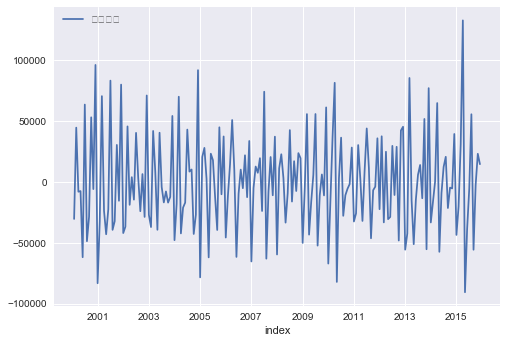

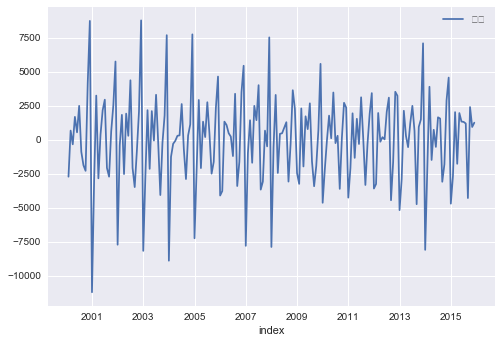

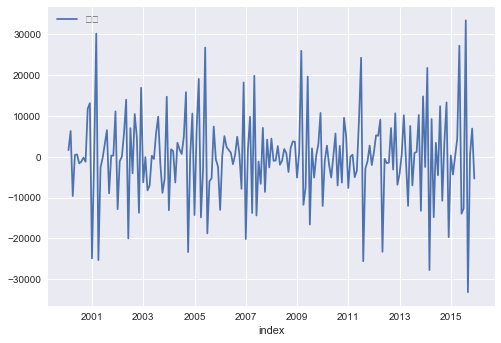

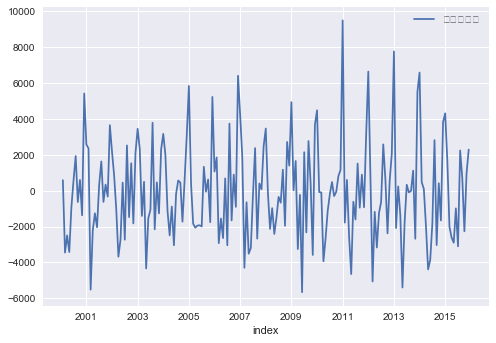

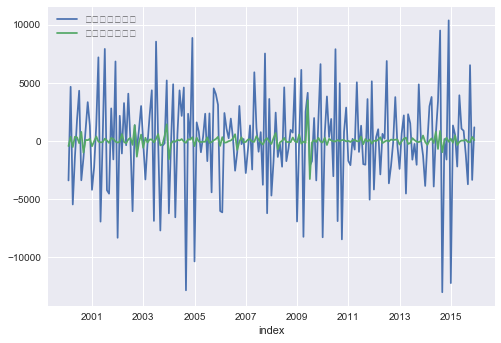

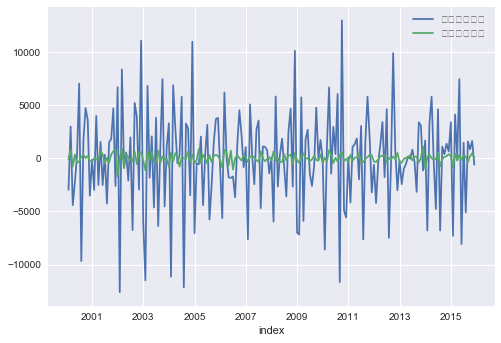

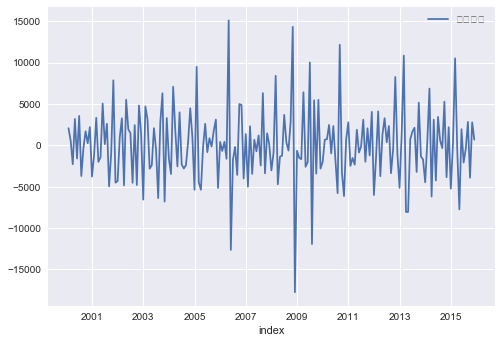

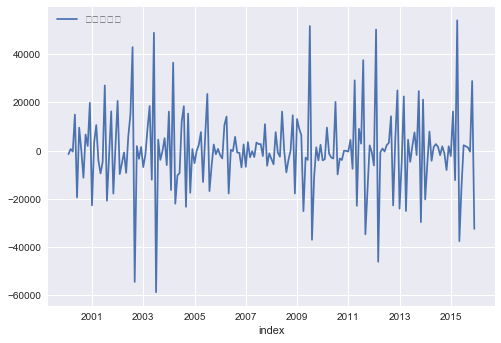

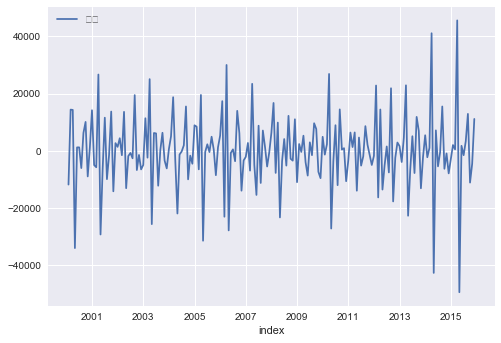

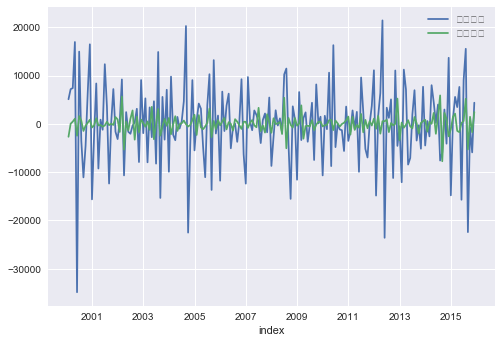

In [193]:
#差分
consumption_diff.plot()
food_diff.plot()
estate_diff.plot()
utility_diff.plot()
furniture_diff.plot()
cloth_diff.plot()
medical_diff.plot()
com_diff.plot()
edu_diff.plot()
edu_fun_diff.plot()

In [194]:
diff_data_2 = pd.concat([consumption_diff,food_diff,estate_diff,utility_diff,furniture_diff,cloth_diff,medical_diff,com_diff,edu_diff,edu_fun_diff],axis=1)

In [195]:
diff_data_2.columns = [
    'consumption'
    ,'food'
    ,'estate'
    ,'utility'
    ,'furniture'
    ,'furniture_2'
    ,'cloth'
    ,'cloth_2'
    ,'medical'
    ,'telecom'
    ,'education'
    ,'edu_fun'
    ,'edu_fun_2'
]

In [196]:
#原系列に対するADF検定
print (st.adfuller(diff_data_2['consumption'].values.ravel()))
print (st.adfuller(diff_data_2['food'].values.ravel()))
print (st.adfuller(diff_data_2['estate'].values.ravel()))
print (st.adfuller(diff_data_2['utility'].values.ravel()))
print (st.adfuller(diff_data_2['furniture'].values.ravel()))
print (st.adfuller(diff_data_2['cloth'].values.ravel()))
print (st.adfuller(diff_data_2['medical'].values.ravel()))
print (st.adfuller(diff_data_2['telecom'].values.ravel()))
print (st.adfuller(diff_data_2['education'].values.ravel()))
print (st.adfuller(diff_data_2['edu_fun'].values.ravel()))

(-8.00045229539132, 2.3416464404906063e-12, 10, 180, {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}, 4047.3788406504073)
(-5.943297617988646, 2.2344834561067752e-07, 12, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 3060.00084139562)
(-9.13103671408466, 3.021659197164476e-15, 7, 183, {'1%': -3.466598080268425, '5%': -2.8774669520682674, '10%': -2.5752604356654425}, 3659.7151446837843)
(-3.854636619455427, 0.002395255619431294, 12, 178, {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}, 3079.5884647970747)
(-8.746247263959106, 2.917464230165172e-14, 10, 180, {'1%': -3.4672111510631, '5%': -2.877734766803841, '10%': -2.575403364197531}, 3312.534510452919)
(-5.491233715509809, 2.1729370704343348e-06, 15, 175, {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}, 3327.7100952840483)
(-9.957125824581112, 2.4275200063309978e-17, 6, 184, {'1%': -3.46639823077407

# みごとなまでに定常過程になったーよ！

In [197]:
x_train = diff_data
y_train = diff_data_2

In [198]:
#天候データ
x_train = x_train.loc[:,['avg_temp','sun','avg_wind','rain_sum']]
x_train.columns = ['temp','sun','wind','rain']
#目的変数データ
y_test = y_train.loc[:,['consumption']]
#複数の目的変数データ, この処理に特に意味ないけど整理するために入れた
tar_data = tar_data

# 気温がもっとも効果ありそう
# ARIMAモデルで推定じゃ！

# https://logics-of-blue.com/time-series-forecast-by-machine-learning/ 参考

# まずはARモデル！！

In [199]:
#消費支出のみでの自己相関
ts_acf = st.acf(y_test,nlags=40)
print (ts_acf)

[ 1.         -0.3780117  -0.25390004  0.03277107  0.22950429 -0.02290466
 -0.23781948  0.06674476  0.10385042  0.13280119 -0.23435538 -0.19677877
  0.45945653 -0.10550038 -0.21517809  0.05845617  0.14740541  0.04133664
 -0.22747373 -0.00472768  0.19665222  0.06548124 -0.18082151 -0.22573833
  0.43050819 -0.11362272 -0.14837514 -0.00877914  0.12995693  0.12214752
 -0.27948631  0.03829691  0.10730501  0.14927712 -0.26689704 -0.05971039
  0.32151098 -0.15705281 -0.07782269 -0.01113084  0.13267684]


In [200]:
#消費支出のみでの偏自己相関
par_ts_acf_2 = st.pacf(y_test.values.ravel(),nlags=40)
print (par_ts_acf_2)

[ 1.00000000e+00 -3.80001234e-01 -4.68663154e-01 -4.31347375e-01
 -1.58634278e-01 -7.18445556e-03 -1.84688714e-01 -1.97001823e-01
 -2.33773750e-01  8.59405187e-02  2.74619471e-02 -4.16355114e-01
  4.13931548e-03 -6.22121005e-02 -1.68529803e-01  3.26157741e-04
 -9.55304719e-02  7.29522624e-02  1.51865908e-02 -1.82006910e-01
  1.14367432e-01  1.42449180e-01  1.83315251e-01 -8.69063113e-02
  8.25582771e-02 -1.43184361e-02  3.21016073e-02 -1.22070742e-02
 -1.15464838e-01  7.08293945e-02 -1.54575325e-01 -8.42568758e-02
 -9.14169906e-02  2.23592911e-02 -1.87765325e-01 -1.16186116e-01
  5.12184956e-02 -2.13903586e-01 -8.60752480e-02 -1.09818532e-01
 -4.58058614e-02]


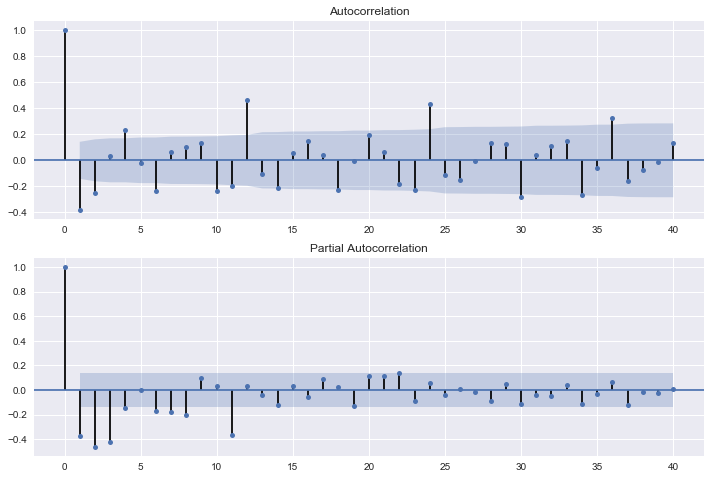

In [201]:
# 自己相関のグラフ
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_test.values.ravel(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_test.values.ravel(), lags=40, ax=ax2)

# autocorrelation の方で、12期つまり1年毎の周期が観測されているよね

# ARMAモデルやるよ！！

In [204]:
#armaの準備
arma_y_test = tar_data.loc[:,['consumption']]

In [205]:
#ARMAの次数推定
arima_4_1 = sm.tsa.arma_order_select_ic(y_test, ic='aic', trend='nc')
arima_4_1

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


{'aic':              0            1            2
 0          NaN  4477.689554  4479.572715
 1  4561.552176  4479.633540  4479.286147
 2  4517.503367  4469.644548  4471.626066
 3  4482.139335  4471.595376  4472.645620
 4  4480.103356  4467.398990  4469.389970, 'aic_min_order': (4, 1)}

In [217]:
arma = ARMA(y_test,order = [4,1,1]).fit(dist=False)
print (arma.params)

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


const               -137.016297
ar.L1.consumption      0.081099
ar.L2.consumption     -0.118261
ar.L3.consumption      0.106270
ar.L4.consumption      0.256129
ma.L1.consumption     -1.000000
dtype: float64


/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


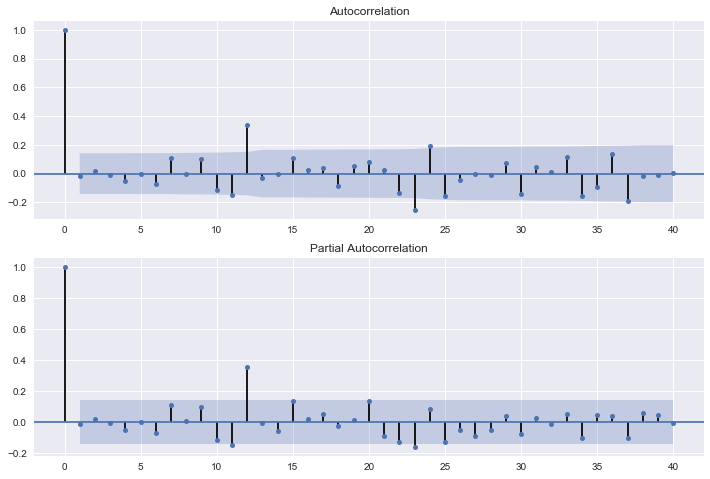

In [218]:
resid = arma.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

# 周期残ってそう

In [214]:
#summary
arma.summary()

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            consumption   No. Observations:                  191
Model:                     ARMA(4, 1)   Log Likelihood               -2226.737
Method:                       css-mle   S.D. of innovations          27629.268
Date:                Mon, 15 Jan 2018   AIC                           4467.474
Time:                        00:45:14   BIC                           4490.240
Sample:                    02-01-2000   HQIC                          4476.695
                         - 12-01-2015                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -137.0163     51.906     -2.640      0.009    -238.751     -35.282
ar.L1.consumption     0.0811      0.070      1.153      0.251      -0.057       0.219
ar.L2.consumption    -0.1183      0.070     -1.691      0.093      -0.255       0.019
ar.L3.consumption     0.1063      0.070      1.517      0.131      -0.031       0.244
ar.L4.consumption     0.2561      0.070      3.658      0.000       0.119       0.393
ma.L1.consumption    -1.0000      0.017    -59.037      0.000      -1.033      -0.967
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3478           -0.0000j            1.3478           -0.0000
AR.2           -0.0511           -1.3198j            1.3208           -0.2562
AR.3           -0.0511           +1.3198j            1.3208            0.2562
AR.4           -1.6605           -0.0000j            1.6605           -0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [278]:
arma_pred = arma.predict('2000-02-01','2016-12-01')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


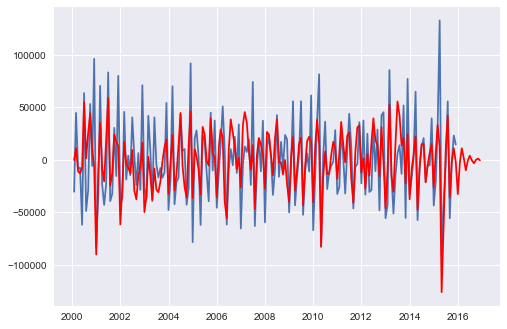

In [280]:
plt.plot(y_test)
plt.plot(arma_pred, "r")

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


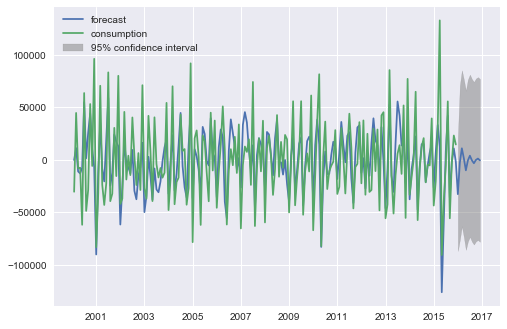

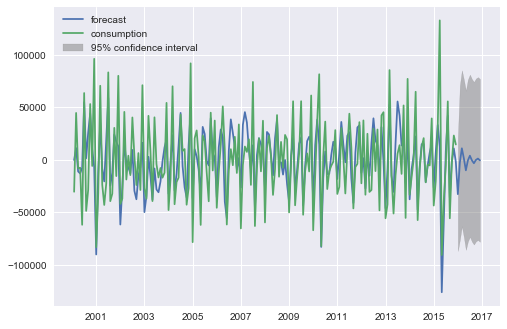

In [250]:
# armaによる予測モデル
arma.plot_predict('2000-02-01','2016-12-01')

# そのまま ARIMAもやるよ!!

In [210]:
arima = ARIMA(y_test,order = [4,1,1]).fit(dist=False)
print (arima.params)

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


const                  2.801584
ar.L1.D.consumption   -0.806488
ar.L2.D.consumption   -0.792665
ar.L3.D.consumption   -0.523798
ar.L4.D.consumption   -0.140475
ma.L1.D.consumption   -0.999964
dtype: float64


/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


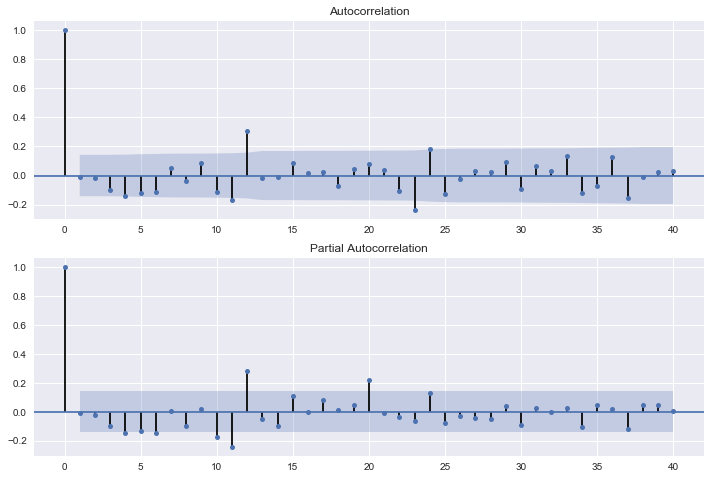

In [211]:
resid = arima.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

In [215]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.consumption   No. Observations:                  190
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -2227.621
Method:                       css-mle   S.D. of innovations          29201.669
Date:                Mon, 15 Jan 2018   AIC                           4469.242
Time:                        00:45:21   BIC                           4491.971
Sample:                    03-01-2000   HQIC                          4478.449
                         - 12-01-2015                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.8016     12.004      0.233      0.816     -20.726      26.329
ar.L1.D.consumption    -0.8065      0.072    -11.216      0.000      -0.947      -0.666
ar.L2.D.consumption    -0.7927      0.085     -9.376      0.000      -0.958      -0.627
ar.L3.D.consumption    -0.5238      0.084     -6.206      0.000      -0.689      -0.358
ar.L4.D.consumption    -0.1405      0.072     -1.954      0.052      -0.281       0.000
ma.L1.D.consumption    -1.0000      0.014    -73.158      0.000      -1.027      -0.973
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0498           -1.2696j            1.2706           -0.2438
AR.2            0.0498           +1.2696j            1.2706            0.2438
AR.3           -1.9142           -0.8635j            2.0999           -0.4326
AR.4           -1.9142           +0.8635j            2.0999            0.4326
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [276]:
arima_pred = arima.predict('2000-03-01','2016-12-01')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


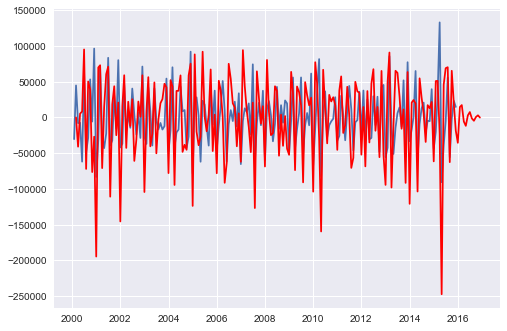

In [277]:
plt.plot(y_test)
plt.plot(arimax_pred, "r")

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


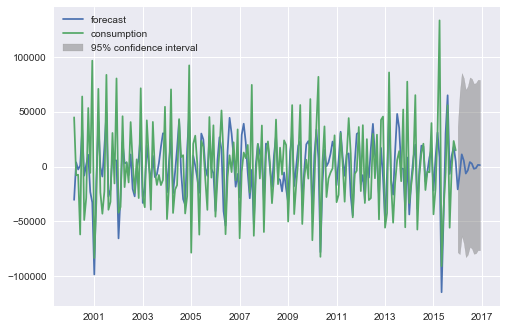

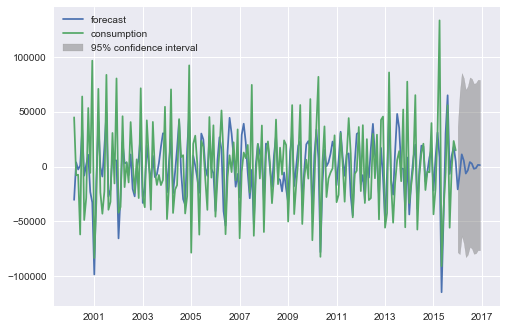

In [254]:
#ARIMAの予測
arima.plot_predict('2000-03-01','2016-12-01')

# SARIMAXをつかうんじゃー！

In [255]:
sarimax = SARIMAX(y_test, order=(4,1,1), seasonal_order=(1,1,1,12)).fit()

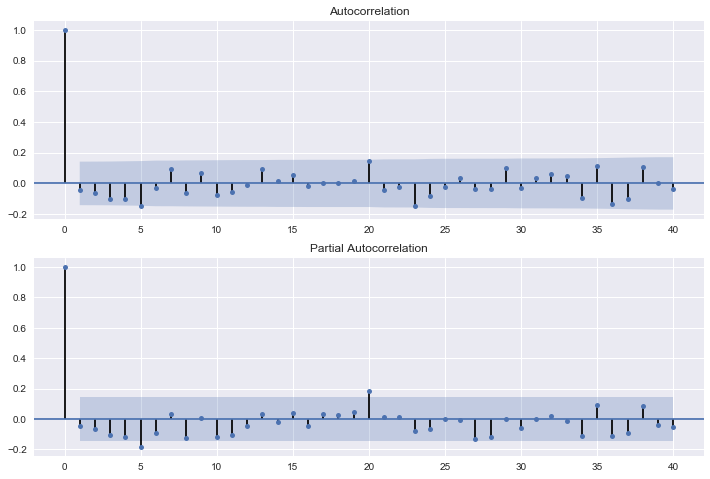

In [256]:
resid = sarimax.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

# 周期性消えてそう

In [271]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                        consumption   No. Observations:                  191
Model:             SARIMAX(4, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2083.385
Date:                            Mon, 15 Jan 2018   AIC                           4182.771
Time:                                    01:31:24   BIC                           4208.789
Sample:                                02-01-2000   HQIC                          4193.309
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6324      0.211     -3.001      0.003      -1.045      -0.219
ar.L2         -0.4693      0.268     -1.749      0.080      -0.995       0.057
ar.L3         -0.3191      0.245     -1.303      0.193      -0.799       0.161
ar.L4         -0.0727      0.211     -0.344      0.731      -0.487       0.341
ma.L1         -0.9791      0.170     -5.751      0.000      -1.313      -0.645
ar.S.L12       0.0275      0.334      0.082      0.935      -0.628       0.683
ma.S.L12      -0.7413      0.321     -2.310      0.021      -1.370      -0.112
sigma2      1.462e+09   1.18e-10   1.23e+19      0.000    1.46e+09    1.46e+09
===================================================================================
Ljung-Box (Q):                       58.43   Jarque-Bera (JB):                68.09
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.78   Skew:                             1.13
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.71e+35. Standard errors may be unstable.
"""

In [272]:
sarimax_pred = sarimax.predict('2000-02-01','2016-12-01')

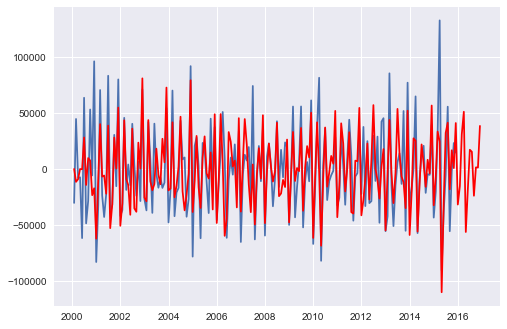

In [273]:
plt.plot(y_test)
plt.plot(sarimax_pred, "r")

In [336]:
#予測データデータフレームの形成
x_arma_pred = pd.DataFrame(arma_pred).loc['2016-01-01':'2016-10-01']
x_arima_pred = pd.DataFrame(arima_pred).loc['2016-01-01':'2016-10-01']
x_sarimax_pred = pd.DataFrame(sarimax_pred).loc['2016-01-01':'2016-10-01']

In [337]:
dat2016 = pd.read_excel('yoko_econ.xlsx',sheetname='2016').T

/Users/Taishi/anaconda/lib/python3.6/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [338]:
y_true_value = dat2016.loc[:,['消費支出']].dropna()
y_true_value.columns = ['consumption']

In [347]:
# 平均二乗誤差を評価するためのメソッドを呼び出し
from sklearn.metrics import mean_squared_error
# 検証用データに関して平均二乗誤差を出力
print (sqrt(mean_squared_error(y_true_value, x_arma_pred)))
print (sqrt(mean_squared_error(y_true_value, x_arima_pred)))
print (sqrt(mean_squared_error(y_true_value, x_sarimax_pred)))

337666.0782024016
336224.9541796184
336963.3742661641


# ARMAモデルが一番評価高いジャンwww
## ARMA > SARIMA > ARIMA

# VARモデルで推測じゃ

In [124]:
#差分に対してrandom forestすることでどれが目的変数に影響あるかを調べる
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(x_train, y_test)
print('Training done using Random Forest')

Training done using Random Forest


/Users/Taishi/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


/Users/Taishi/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


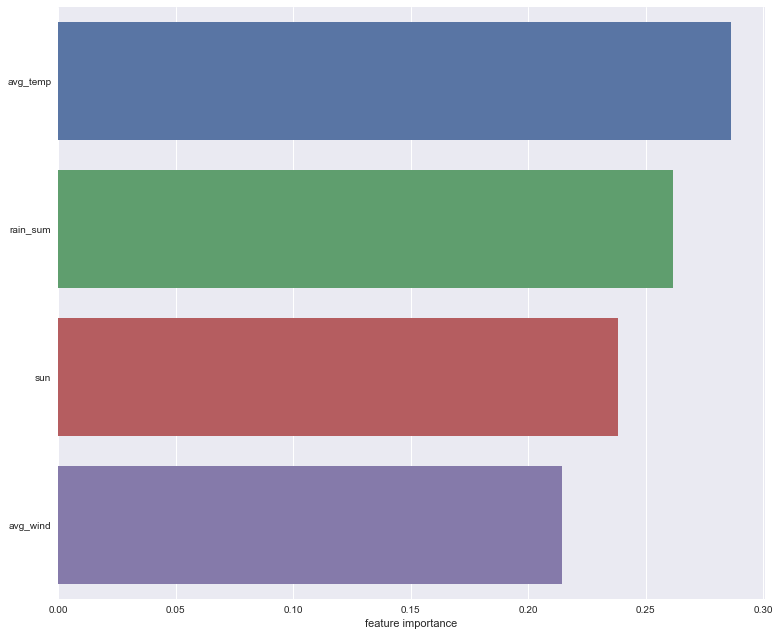

In [125]:
#plot
ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
sns.barplot(x=rf.feature_importances_[ranking], y=x_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [126]:
from statsmodels.tsa.api import VAR, DynamicVAR

In [153]:
var_data = pd.concat([x_train,y_test],axis=1)

In [154]:
model = VAR(var_data)

In [155]:
model.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         39.91        40.00    2.150e+17        39.95
1         38.14        38.69    3.682e+16        38.36
2         37.58        38.58    2.104e+16        37.99
3         36.73       38.17*    8.934e+15        37.31
4         36.40        38.29    6.491e+15        37.17
5         36.16        38.50    5.129e+15        37.11
6         35.94        38.73    4.120e+15       37.07*
7         35.88        39.12    3.923e+15        37.19
8         35.58        39.27    2.953e+15        37.08
9         35.48        39.62    2.726e+15        37.16
10        35.45        40.05    2.719e+15        37.32
11       35.21*        40.25   2.188e+15*        37.25
12        35.30        40.79    2.487e+15        37.53
13        35.33        41.28    2.679e+15        37.74
14        35.37        41.77    2.938e+15        37.97
15        

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


{'aic': 11, 'bic': 3, 'fpe': 11, 'hqic': 6}

In [348]:
#モデルはaic
var_result = model.fit(maxlags=12, ic='aic')

/Users/Taishi/anaconda/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


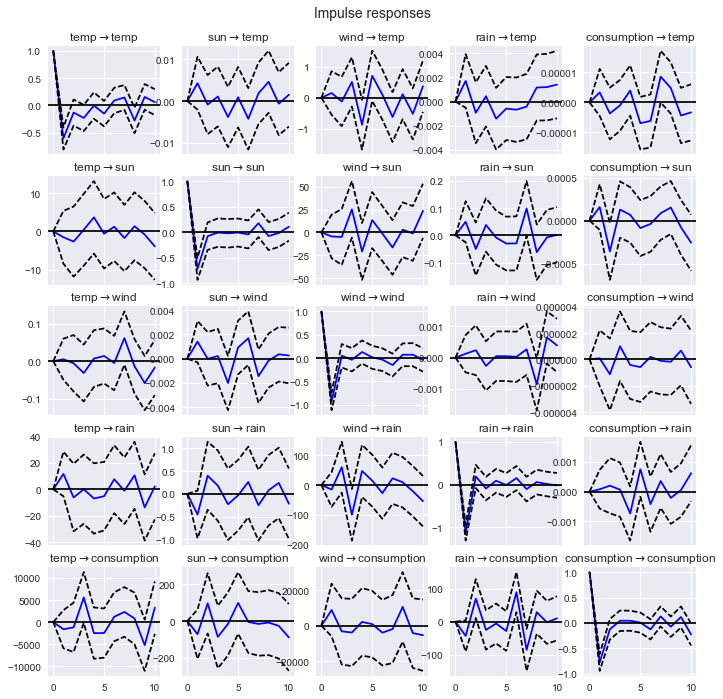

In [349]:
irf = var_result.irf(10)
irf.plot(orth=False)

# 差分で、相関をみるよ

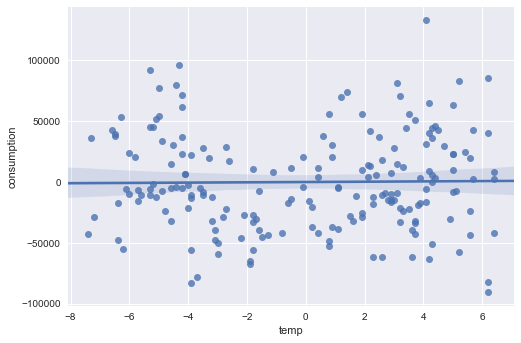

In [366]:
sns.regplot(x=x_train['temp'],y=y_train['consumption'])

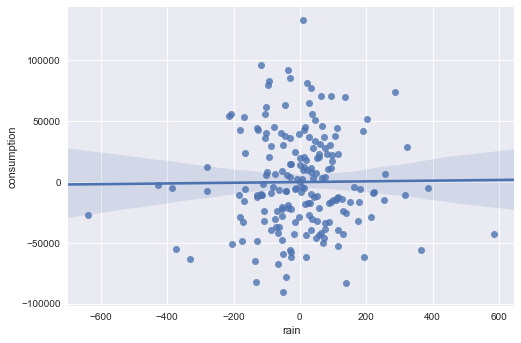

In [367]:
sns.regplot(x=x_train['rain'],y=y_train['consumption'])

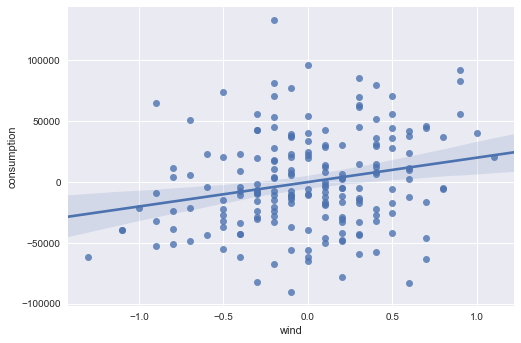

In [368]:
sns.regplot(x=x_train['wind'],y=y_train['consumption'])

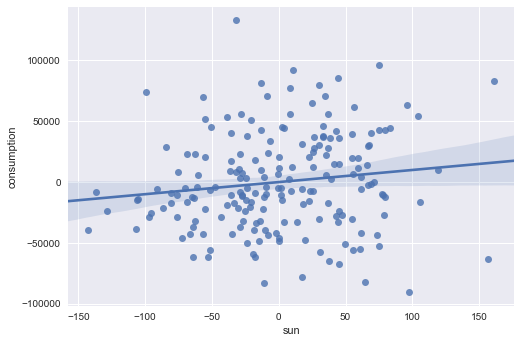

In [369]:
sns.regplot(x=x_train['sun'],y=y_train['consumption'])

# Granger因果で、相関分析！！

In [350]:
granger_temp = st.grangercausalitytests(var_data.loc[:,['consumption','temp']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4219  , p=0.5168  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=0.4286  , p=0.5127  , df=1
likelihood ratio test: chi2=0.4282  , p=0.5129  , df=1
parameter F test:         F=0.4219  , p=0.5168  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0061  , p=0.1374  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=4.1213  , p=0.1274  , df=2
likelihood ratio test: chi2=4.0770  , p=0.1302  , df=2
parameter F test:         F=2.0061  , p=0.1374  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4189  , p=0.2388  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=4.4212  , p=0.2194  , df=3
likelihood ratio test: chi2=4.3701  , p=0.2242  , df=3
parameter F test:         F=1.4189  , p=0.2388  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3709  , p=0.2459  

In [351]:
granger_rain = st.grangercausalitytests(var_data.loc[:,['consumption','rain']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1941  , p=0.0137  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=6.2935  , p=0.0121  , df=1
likelihood ratio test: chi2=6.1915  , p=0.0128  , df=1
parameter F test:         F=6.1941  , p=0.0137  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1762  , p=0.0065  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=10.6337 , p=0.0049  , df=2
likelihood ratio test: chi2=10.3454 , p=0.0057  , df=2
parameter F test:         F=5.1762  , p=0.0065  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5058  , p=0.0606  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=7.8080  , p=0.0502  , df=3
likelihood ratio test: chi2=7.6502  , p=0.0538  , df=3
parameter F test:         F=2.5058  , p=0.0606  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5859  , p=0.1800  

# おおおおぉおおおおおおおおおおおおおお
雨量から、消費量は推定できそうじゃー！

In [352]:
granger = st.grangercausalitytests(var_data.loc[:,['consumption','wind']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1238  , p=0.7254  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=0.1257  , p=0.7229  , df=1
likelihood ratio test: chi2=0.1257  , p=0.7229  , df=1
parameter F test:         F=0.1238  , p=0.7254  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7454  , p=0.4760  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=1.5313  , p=0.4650  , df=2
likelihood ratio test: chi2=1.5252  , p=0.4665  , df=2
parameter F test:         F=0.7454  , p=0.4760  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4627  , p=0.7087  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=1.4418  , p=0.6958  , df=3
likelihood ratio test: chi2=1.4363  , p=0.6970  , df=3
parameter F test:         F=0.4627  , p=0.7087  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3817  , p=0.8216  

# 風量は論外くさい

In [353]:
granger = st.grangercausalitytests(var_data.loc[:,['consumption','sun']], maxlag=12, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5152  , p=0.0624  , df_denom=187, df_num=1
ssr based chi2 test:   chi2=3.5715  , p=0.0588  , df=1
likelihood ratio test: chi2=3.5384  , p=0.0600  , df=1
parameter F test:         F=3.5152  , p=0.0624  , df_denom=187, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3552  , p=0.0370  , df_denom=184, df_num=2
ssr based chi2 test:   chi2=6.8928  , p=0.0319  , df=2
likelihood ratio test: chi2=6.7701  , p=0.0339  , df=2
parameter F test:         F=3.3552  , p=0.0370  , df_denom=184, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1748  , p=0.0926  , df_denom=181, df_num=3
ssr based chi2 test:   chi2=6.7766  , p=0.0794  , df=3
likelihood ratio test: chi2=6.6573  , p=0.0837  , df=3
parameter F test:         F=2.1748  , p=0.0926  , df_denom=181, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0505  , p=0.0893  

# Sunも良さそうだけども、どうなんだろ。雨増えたらsun減るとか。。？